In [17]:
# !pip install dowhy econml

In [18]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

import networkx as nx
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

import dowhy
from dowhy import CausalModel

In [19]:
SAMPLES_SIZE = 100000

In [20]:
# A Simple Data Set
G = nx.DiGraph()
G.add_edges_from([
    ('U', 'X'),
    ('U', 'Y'),
    ('X', 'Z'),
    ('Z', 'Y')
])

U = stats.truncnorm(-np.infty, np.infty, scale=4).rvs(SAMPLES_SIZE)
X = 0.7*U + stats.norm(scale=2).rvs(SAMPLES_SIZE)
Z = -0.6*X + stats.norm(scale=2).rvs(SAMPLES_SIZE)
Y = 0.7*Z + 0.25*U + stats.norm(scale=2).rvs(SAMPLES_SIZE)

# QUESTION 1
# Using PATH method, what is the expected causal effect of X on Y?

In [25]:
# Try regular OLS
data = pd.DataFrame({'X': X, 'Z': Z})
data = pd.DataFrame({'X': X, 'U': U})
data = sm.add_constant(data, prepend=True)
model = sm.OLS(Y, data) # Ordinary Linear Regression
results = model.fit()
results.summary()

# QUESTION 2
# What can you identify from this result in combination with the graph above

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     5982.
Date:                Sat, 08 Feb 2025   Prob (F-statistic):               0.00
Time:                        19:15:58   Log-Likelihood:            -2.3126e+05
No. Observations:              100000   AIC:                         4.625e+05
Df Residuals:                   99997   BIC:                         4.626e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0064      0.008     -0.822      0.411      -0.021       0.009
X             -0.4147      0.004   -107.060      0.000      -0.422      -0.407
U              0.2469      0.003     74.047      0.000       0.240       0.253
==============================================================================
Omnibus:                        3.072   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.215   Jarque-Bera (JB):                3.114
Skew:                          -0.001   Prob(JB):                        0.211
Kurtosis:                       3.027   Cond. No.                         5.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
# Use DoWhy Model
model = CausalModel(
    data=pd.DataFrame({'X': X, 'Y': Y, 'Z': Z}),
    treatment='X',
    outcome='Y',
    graph="\n".join(nx.generate_gml(G))
)

/home/andre/anaconda3/envs/causality/lib/python3.10/site-packages/dowhy/causal_model.py:583: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


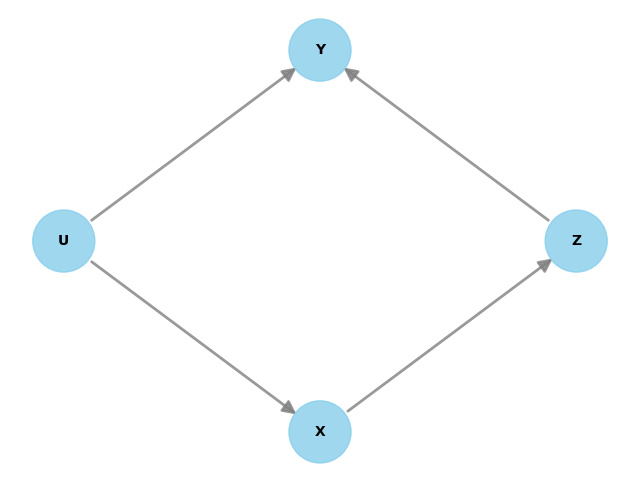

In [7]:
model.view_model()

In [8]:
estimand = model.identify_effect()
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡ d       d       ⎤
E⎢────(Y)⋅────([Z])⎥
 ⎣d[Z]    d[X]     ⎦
Estimand assumption 1, Full-mediation: Z intercepts (blocks) all directed paths from X to Y.
Estimand assumption 2, First-stage-unconfoundedness: If U→{X} and U→{Z} then P(Z|X,U) = P(Z|X)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{Z} and U→Y then P(Y|Z, X, U) = P(Y|Z, X)



In [9]:
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='frontdoor.two_stage_regression')

print(f'Estimate of causal effect (linear regression): {estimate.value}')

# Question 3: Does this match your expection in Q1?

Estimate of causal effect (linear regression): -0.4235442750202307


In [10]:
refute_subset = model.refute_estimate(
    estimand=estimand,
    estimate=estimate,
    method_name="data_subset_refuter",
    subset_fraction=0.4)

In [11]:
print(refute_subset)

Refute: Use a subset of data
Estimated effect:-0.4235442750202307
New effect:-0.4233825064105966
p value:0.94



In [12]:
refute_placebo = model.refute_estimate(
    estimand=estimand,
    estimate=estimate,
    method_name="placebo_treatment_refuter")

In [13]:
print(refute_placebo)

Refute: Use a Placebo Treatment
Estimated effect:-0.4235442750202307
New effect:-0.42354427502023073
p value:0.0



In [14]:
# Another Data Set
G = nx.DiGraph()
G.add_edges_from([
    ('U', 'X'),
    ('U', 'Y'),
    ('X', 'Z'),
    ('Z', 'Y'),
    ('I', 'X')
])

U = stats.truncnorm(0, np.infty, scale=4).rvs(SAMPLES_SIZE)
I = stats.norm(scale=10).rvs(SAMPLES_SIZE)
X = 0.7*U + 0.3*I + stats.norm(scale=2).rvs(SAMPLES_SIZE)
Z = -0.6*X + stats.norm(scale=2).rvs(SAMPLES_SIZE)
Y = 0.7*Z + 0.25*U + stats.norm(scale=2).rvs(SAMPLES_SIZE)

In [15]:
# Use DoWhy Model
model = CausalModel(
    data=pd.DataFrame({'X': X, 'Y': Y, 'Z': Z, 'U': U, 'I': I}),
    treatment='X',
    outcome='Y',
    graph="\n".join(nx.generate_gml(G))
)

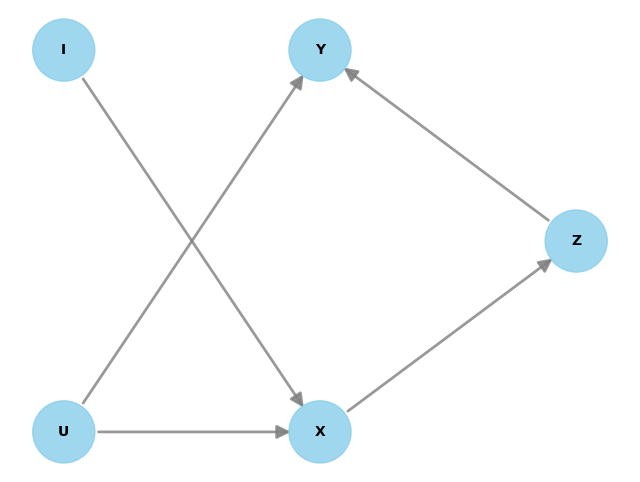

In [16]:
model.view_model()

In [28]:
estimand = model.identify_effect()
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|U])
d[X]        
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,U,U) = P(Y|X,U)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                   -1⎤
 ⎢ d      ⎛ d       ⎞  ⎥
E⎢────(Y)⋅⎜────([X])⎟  ⎥
 ⎣d[I]    ⎝d[I]     ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Y then ¬(U →→{I})
Estimand assumption 2, Exclusion: If we remove {I}→{X}, then ¬({I}→Y)

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡ d       d       ⎤
E⎢────(Y)⋅────([Z])⎥
 ⎣d[Z]    d[X]     ⎦
Estimand assumption 1, Full-mediation: Z intercepts (blocks) all directed paths from X to Y.
Estimand assumption 2, First-stage-unconfoundedness: If U→{X} and U→{Z} then P(Z|X,U) = P(Z|X)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{Z} and U→Y then P(Y|Z, X, U) = P(Y|Z, X)



In [29]:
# No backdoor
data = pd.DataFrame({'X': X})
data = sm.add_constant(data, prepend=True)
model_ols_no_backdoor = sm.OLS(Y, data) # Ordinary Linear Regression
results = model_ols_no_backdoor.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                 3.256e+04
Date:                Fri, 07 Feb 2025   Prob (F-statistic):               0.00
Time:                        17:55:54   Log-Likelihood:            -2.3362e+05
No. Observations:              100000   AIC:                         4.672e+05
Df Residuals:                   99998   BIC:                         4.673e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6639      0.009     73.074      0.000       0.646       0.682
X             -0.3579      0.002   -180.441      0.000      -0.362      -0.354
==============================================================================
Omnibus:                        0.770   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.680   Jarque-Bera (JB):                0.780
Skew:                           0.002   Prob(JB):                        0.677
Kurtosis:                       2.987   Cond. No.                         5.32
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
# Homegrown backdoor
data = pd.DataFrame({'X': X, 'U': U})
data = sm.add_constant(data, prepend=True)
model_ols_backdoor = sm.OLS(Y, data) # Ordinary Linear Regression
results = model_ols_backdoor.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                 1.943e+04
Date:                Fri, 07 Feb 2025   Prob (F-statistic):               0.00
Time:                        17:55:54   Log-Likelihood:            -2.3129e+05
No. Observations:              100000   AIC:                         4.626e+05
Df Residuals:                   99997   BIC:                         4.626e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0265      0.013      2.071      0.038       0.001       0.052
X             -0.4204      0.002   -196.512      0.000      -0.425      -0.416
U              0.2434      0.004     68.970      0.000       0.236       0.250
==============================================================================
Omnibus:                        0.219   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.896   Jarque-Bera (JB):                0.225
Skew:                          -0.003   Prob(JB):                        0.893
Kurtosis:                       2.996   Cond. No.                         9.34
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
estimate_backdoor = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.linear_regression')

print(f'Estimate of causal effect via backdoor (linear regression): {estimate_backdoor.value}')

# QUESTION 4 -- How are the difference between OLS No Backdoor, OLS Backdoor, and DoWhy Backdoor

Estimate of causal effect via backdoor (linear regression): -0.4203599076627909


In [35]:
refute_placebo = model.refute_estimate(
    estimand=estimand,
    estimate=estimate_backdoor,
    method_name="placebo_treatment_refuter")

In [36]:
print(refute_placebo)

Refute: Use a Placebo Treatment
Estimated effect:-0.4203599076627909
New effect:0.0
p value:1.0



In [37]:
estimate_iv = model.estimate_effect(
    identified_estimand=estimand,
    method_name='iv.instrumental_variable')

print(f'Estimate of causal effect via IV: {estimate_iv.value}')

Estimate of causal effect via IV: -0.41959715974376083


In [38]:
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dml.DML',
    method_params={
        'init_params': {
            'model_y': GradientBoostingRegressor(),
            'model_t': GradientBoostingRegressor(),
            'model_final': LassoCV(fit_intercept=False),
        },
        'fit_params': {}}
)

print(f'Estimate of causal effect (DML): {estimate.value}')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Estimate of causal effect (DML): -0.4195262751695346
